In [1]:
import os
import pickle
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor  # pip install xgboost
from xgbexcel import XGBtoExcel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
!pip install xgbexcel


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Считывание данных

In [2]:
convert = lambda x: x if 0 < x > 150 else 0
convert = np.vectorize(convert)

Функция для нормализации предсказаний

Предсказаний меньше нуля никак не может быть, так что мы можем ограничить все предсказания

In [3]:
warnings.filterwarnings("ignore")

Отключение предупреждений от моделей

In [4]:
if not os.path.isdir("raw_data"):
    os.chdir("../")

Установка рабочей директории (тк данные располагаются на папку выше)

In [5]:
data = pd.read_excel("raw_data/Статистика_для_графиков_3_д_ТЭЦ2_УРУТ_130.xlsx")

In [6]:
data.columns

Index([                                                  'Дата',
                           'Выработка электроэнергии ТА гр.130',
                                 'Отпуск тепла из ТО ТА гр.130',
       'Удельный расход условного топлива на отпуск э/э гр.130',
                                                   'Unnamed: 4',
                                       'Предсказание полином 2',
                                           0.033374592702317095],
      dtype='object')

Считывание данных

# Предобработка данных

In [7]:
target = "Удельный расход условного топлива на отпуск э/э гр.130"

In [8]:
columns_for_predictions = [
    column
    for column in data.columns[:-1]
    if "130" in column and column != "Удельный расход тепла на выработку э/э ТА гр.130"
]

Получаем все колонки, связанные с "Удельный расход условного топлива на отпуск э/э гр.130"

In [9]:
columns_for_predictions

['Выработка электроэнергии ТА гр.130',
 'Отпуск тепла из ТО ТА гр.130',
 'Удельный расход условного топлива на отпуск э/э гр.130']

In [11]:
data.isna().sum()

Дата                                                         0
Выработка электроэнергии ТА гр.130                           0
Отпуск тепла из ТО ТА гр.130                                 0
Удельный расход условного топлива на отпуск э/э гр.130       0
Unnamed: 4                                                1090
Предсказание полином 2                                       0
0.033374592702317095                                         0
dtype: int64

In [12]:
data = data[columns_for_predictions]

# Обработка выбросов

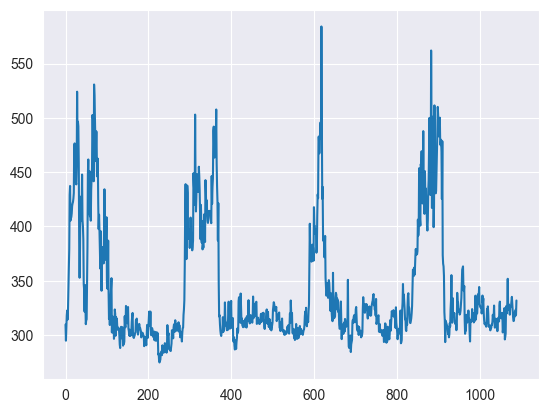

In [13]:
plt.plot(data[target]);

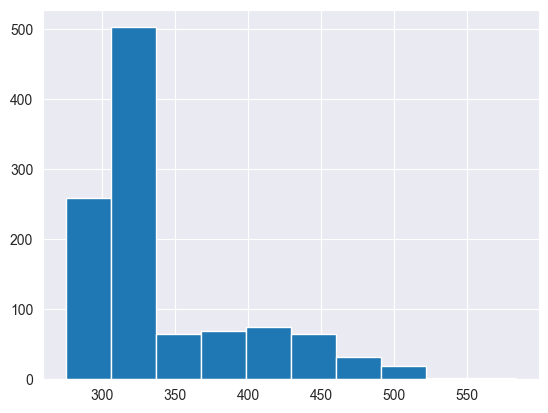

In [14]:
plt.hist(data[target]);

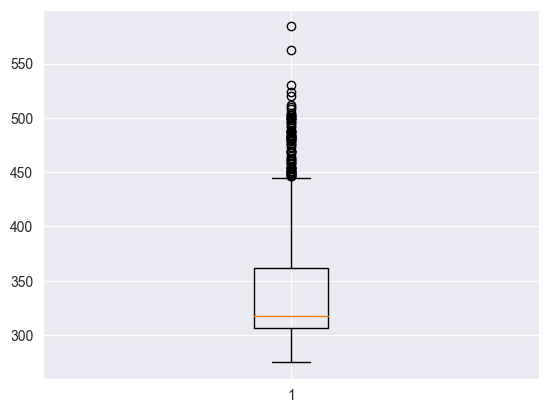

In [15]:
plt.boxplot(data[target]);

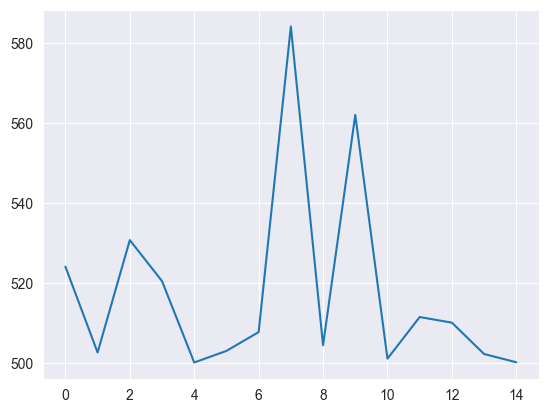

In [16]:
plt.plot(np.array(data.loc[data[target] > 500][target]));

In [17]:
data = data.loc[data[target] < 507]
data = data.loc[data[target] > 100]

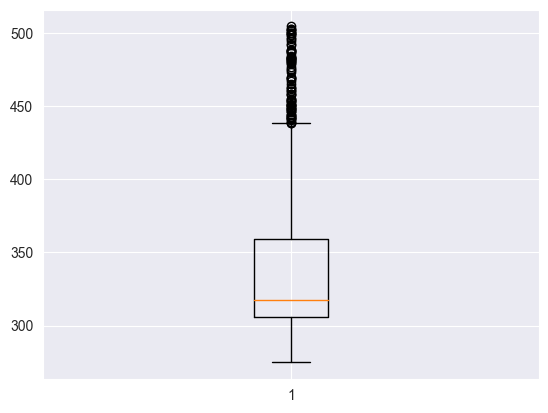

In [18]:
plt.boxplot(data[target]);

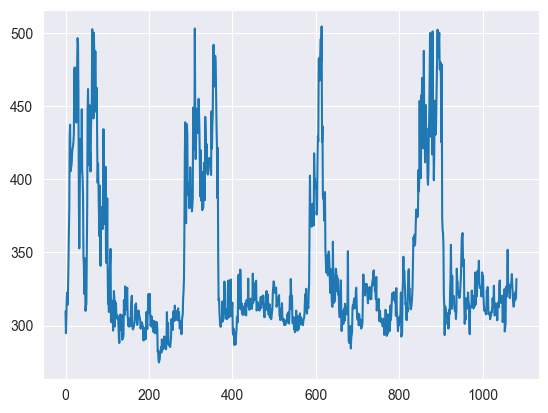

In [19]:
plt.plot(np.array(data[target]));

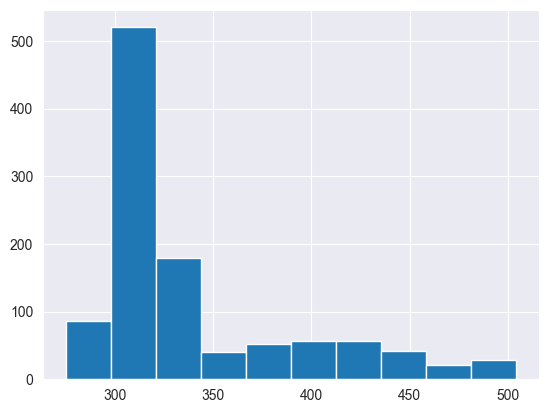

In [20]:
plt.hist(data[target]);

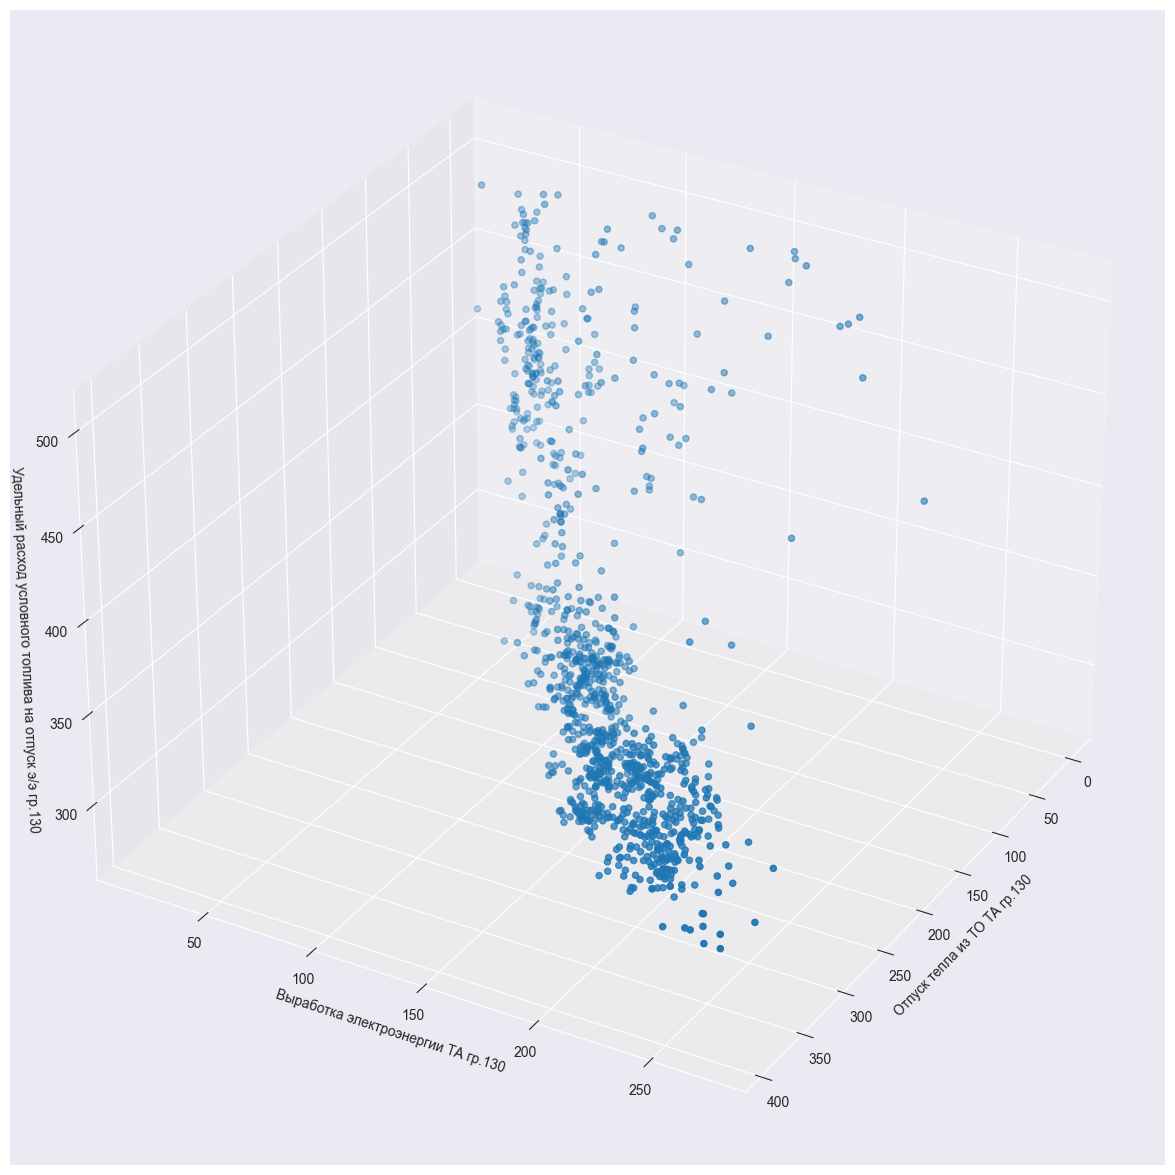

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
fig.set_figheight(15)
fig.set_figwidth(15)
ax.scatter(
    data[columns_for_predictions[1]],
    data[columns_for_predictions[0]],
    data[columns_for_predictions[2]]
)

ax.view_init(30, 30)
ax.set_xlabel(columns_for_predictions[1])
ax.set_ylabel(columns_for_predictions[0])
ax.set_zlabel(columns_for_predictions[2]);

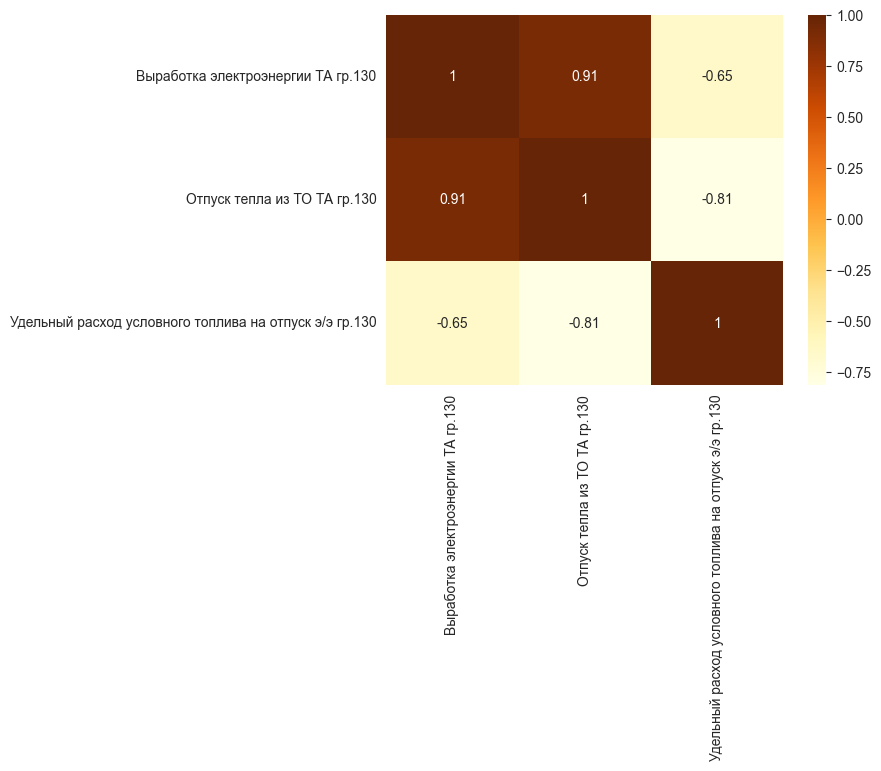

In [22]:
sns.heatmap(
    data.corr(), annot=True,
    cmap=sns.color_palette("YlOrBr", as_cmap=True)
);

# Создание датасета для обучения
## Разделение данных

In [67]:
X = data.drop(target, axis=1)

In [68]:
y = data[target]

In [69]:
out_shape = 1

# Разделение на тренировочную и тестовую выборки

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=30)

# XGB

In [71]:
model = XGBRegressor()

In [72]:
X = np.array(X)
y = np.array(y)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [73]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

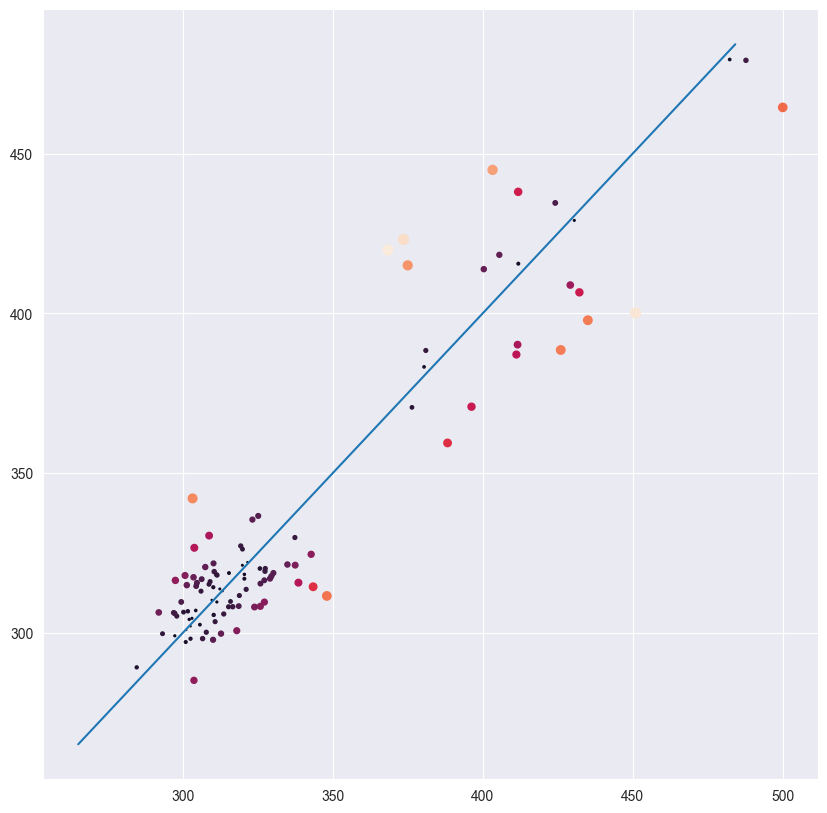

In [74]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [75]:
predictions = np.array(model.predict(X_test))

In [76]:
# data["predictions"] = predictions
# data.to_excel("Статистика для графиков 3 д ТЭЦ2 (УРУТ-130).xlsx")

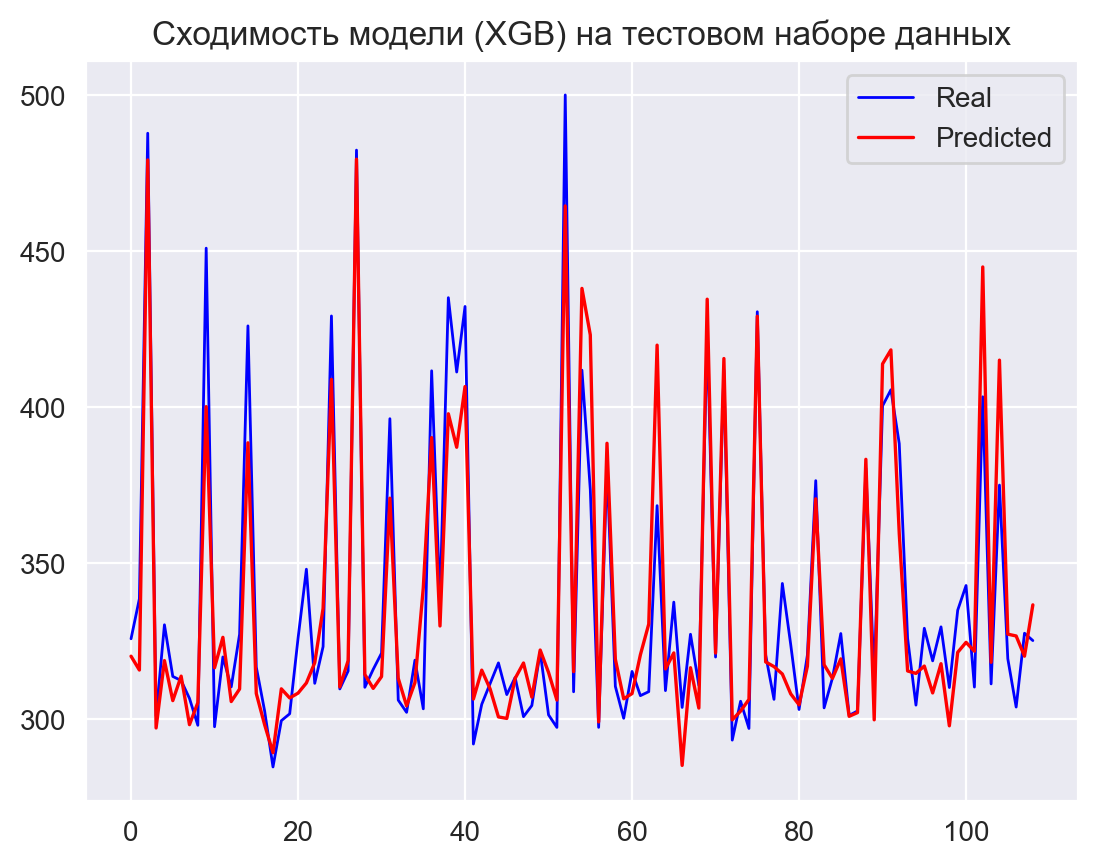

In [77]:
plt.figure(dpi=200)
plt.title("Сходимость модели (XGB) на тестовом наборе данных")
plt.plot(y_test, color="blue", label="Real", linewidth=1)
plt.plot(predictions, "r", label="Predicted", linewidth=1.2)
plt.legend()
plt.savefig("predictions/graphs/xgb_test_plot.png")
plt.savefig("predictions/graphs/xgb_test_plot.svg")
plt.show()

In [78]:
r2_score(y_test, predictions)

0.8681202611339234

In [79]:
for real, pred in zip(y_test, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 338.566673, pred: 315.73089599609375, diff: 22.83577700390623
real: 450.898516, pred: 400.1224365234375, diff: 50.77607947656247
real: 425.995021, pred: 388.5297546386719, diff: 37.46526636132813
real: 348.03684, pred: 311.58612060546875, diff: 36.450719394531234
real: 429.177924, pred: 408.84765625, diff: 20.33026775000002
real: 396.255965, pred: 370.7890930175781, diff: 25.46687198242188
real: 303.300946, pred: 342.0945129394531, diff: 38.793566939453115
real: 411.607633, pred: 390.195068359375, diff: 21.41256464062502
real: 435.033737, pred: 397.8387756347656, diff: 37.19496136523435
real: 411.209838, pred: 387.1070251464844, diff: 24.102812853515616
real: 432.218168, pred: 406.5627136230469, diff: 25.655454376953116
real: 499.985903, pred: 464.4230651855469, diff: 35.56283781445313
real: 411.812614, pred: 438.0095520019531, diff: 26.19693800195313
real: 373.586281, pred: 423.1063232421875, diff: 49.520042242187515
real: 308.802867, pred: 330.45635986328125, diff: 21.653492863

In [80]:
abs(y_test - predictions).max()

51.419343099609364

In [81]:
model = XGBRegressor()

In [82]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [83]:
predictions = np.array(model.predict(X))

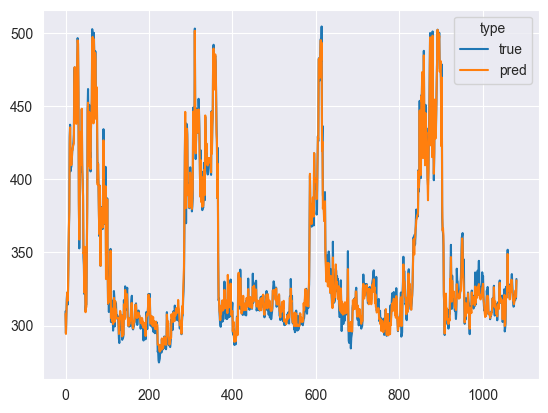

In [84]:
plt.plot(y, label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [85]:
r2_score(y, predictions)

0.9927046688238708

In [86]:
for real, pred in zip(y, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 333.258783, pred: 312.3085021972656, diff: 20.95028080273437
real: 345.181419, pred: 324.93048095703125, diff: 20.250938042968755


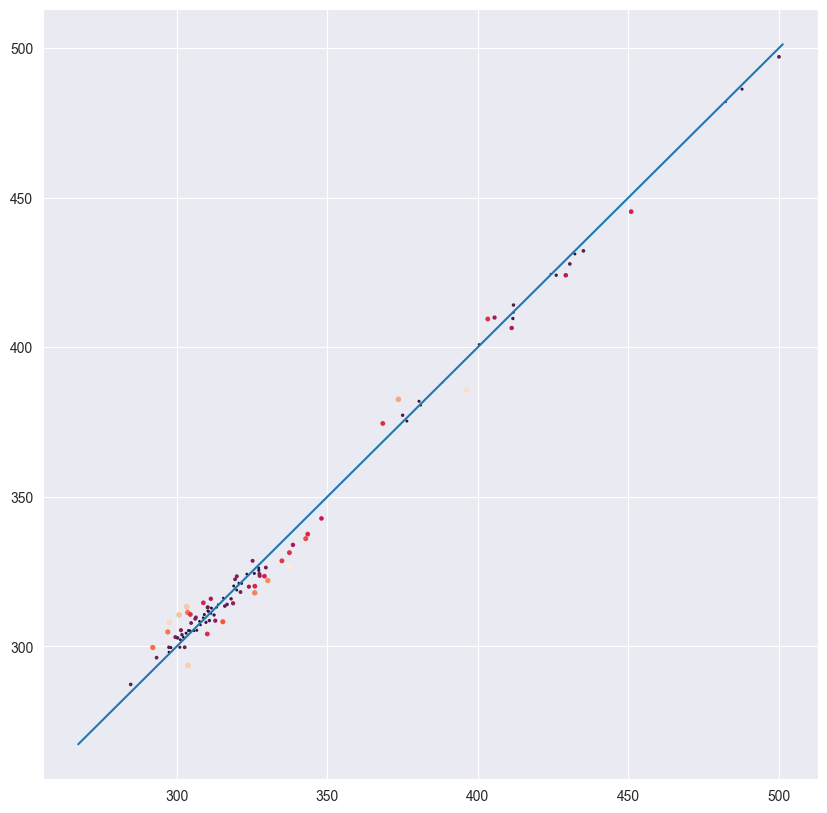

In [87]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [88]:
if not os.path.isdir("models"):
    os.mkdir("models")

In [89]:
with open("models/xgb_fuelTA130_099889.bf", "+wb") as file:
    pickle.dump(model, file)

In [90]:
excel = XGBtoExcel(model)
excel.save_expr("models/xgb0.99.txt")

Saved!


In [91]:
len(XGBtoExcel(model).expression)

91855

# XGB + grid search

In [92]:
X = np.array(X)
y = np.array(y)

In [93]:
model = XGBRegressor(n_estimators=100, max_depth=10, alpha=2)

In [94]:
model.fit(X_train, y_train)

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [95]:
predictions = np.array(model.predict(X_test))

In [96]:
r2_score(y_test, predictions)

0.8697655049381815

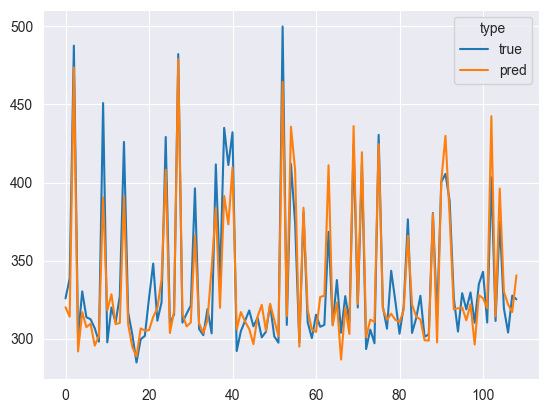

In [97]:
plt.plot(np.array(y_test), label="true")
plt.plot(predictions, label="pred")
plt.legend(title="type")
plt.savefig("predictions.png");

In [98]:
for real, pred in zip(y_test, predictions):
    if abs(real - pred) > 20:
        print(
            "real: {0}, pred: {1}, diff: {2}".format(
                real, pred, abs(real - pred)
            )
        )

real: 338.566673, pred: 314.0183410644531, diff: 24.548331935546855
real: 450.898516, pred: 390.5018615722656, diff: 60.39665442773435
real: 297.561446, pred: 317.98004150390625, diff: 20.41859550390626
real: 425.995021, pred: 391.09075927734375, diff: 34.90426172265626
real: 325.873674, pred: 305.4093933105469, diff: 20.46428068945312
real: 348.03684, pred: 313.8555908203125, diff: 34.181249179687484
real: 429.177924, pred: 408.1360168457031, diff: 21.041907154296894
real: 396.255965, pred: 366.0917663574219, diff: 30.16419864257813
real: 303.300946, pred: 345.25799560546875, diff: 41.95704960546874
real: 411.607633, pred: 383.58502197265625, diff: 28.02261102734377
real: 435.033737, pred: 391.43212890625, diff: 43.601608093749974
real: 411.209838, pred: 373.20074462890625, diff: 38.00909337109374
real: 432.218168, pred: 409.652099609375, diff: 22.56606839062499
real: 300.781156, pred: 321.6441955566406, diff: 20.863039556640615
real: 499.985903, pred: 464.44757080078125, diff: 35.538

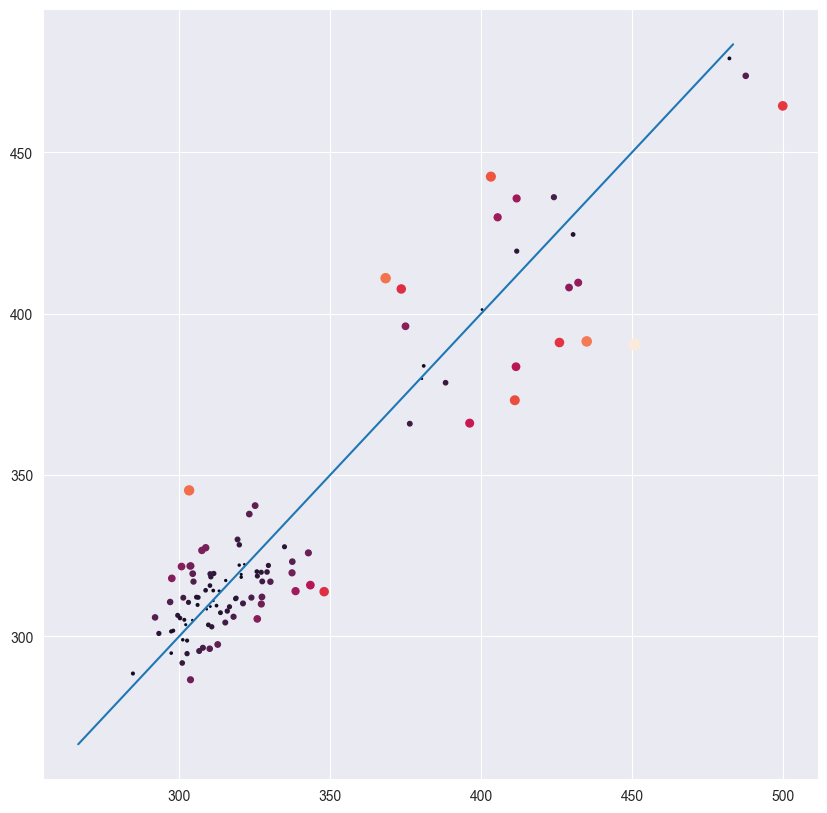

In [99]:
test_predictions = np.array(model.predict(X_test))
area = abs(y_test - test_predictions)
plt.figure(figsize=(10, 10))
plt.plot(
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5),
    np.arange(min(test_predictions) - 20, max(test_predictions) + 5)
)
plt.scatter(y_test, test_predictions, marker='o', s=area, c=area);

In [100]:
model.fit(X, y)

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [101]:
predictions = np.array(model.predict(X))

In [102]:
r2_score(y, predictions)

0.9988329915734091

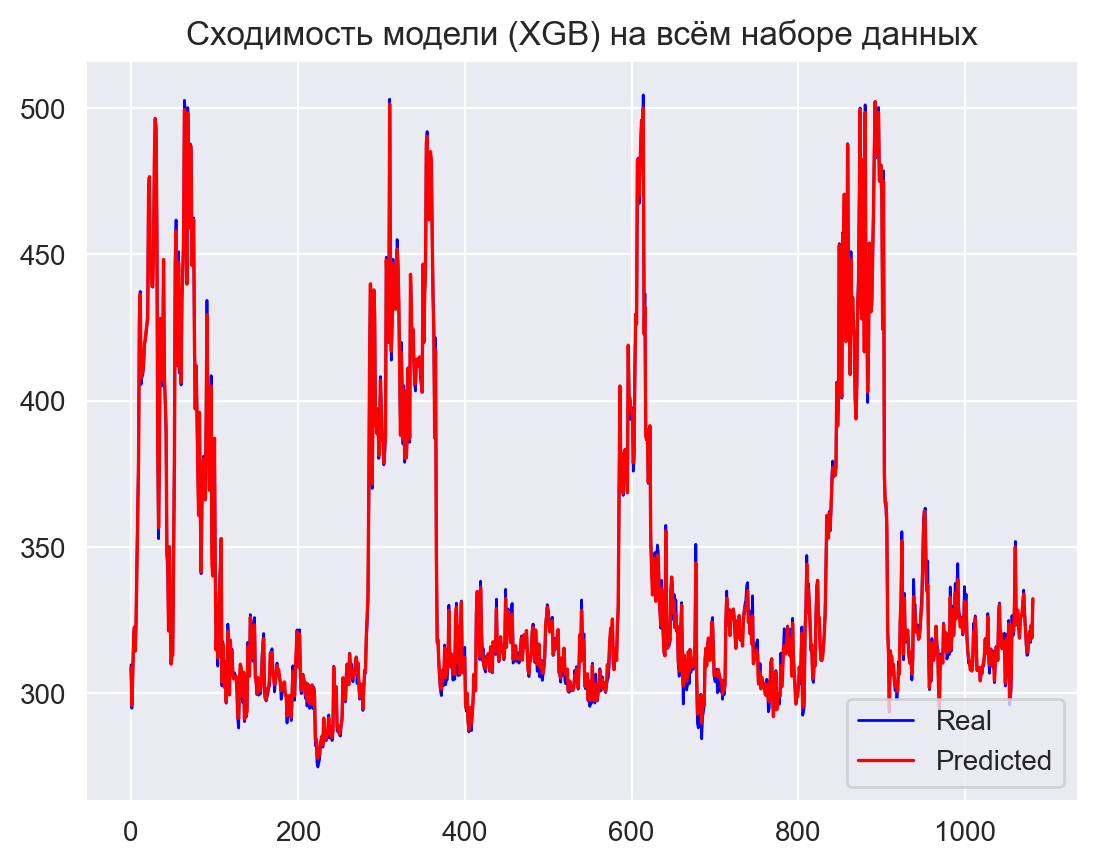

In [103]:
plt.figure(dpi=200)
plt.title("Сходимость модели (XGB) на всём наборе данных")
plt.plot(y, color="blue", label="Real", linewidth=1)
plt.plot(predictions, "r", label="Predicted", linewidth=1.2)
plt.legend()
plt.savefig("predictions/graphs/xgb_plot.png")
plt.savefig("predictions/graphs/xgb_plot.svg")
plt.show()

In [539]:
with open("models/xgb_fuelTA130_099994.bf", "+wb") as file:
    pickle.dump(model, file)